# Introduction

This project shows: 
- ability of writing solid,structured Python code 
- ability of using existing utilities(libraries) for processing and analyzing data.
- ability of utilizing Machine Learning models:
    - CatBoost
    - XGBoost
    - LightGBM
- analytical and data pre-processing skills

Project involves:
1. Data preprocessing
2. Machine Learning model research:
    - Selection of model parameters
    - Choosing the best model to solve the problem

Combined project of the training course "[Specialist in Data Science](https://practicum.yandex.com/data-scientist)" by [Yandex Practicum](https://practicum.yandex.com/).

# Setting up the project

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
!pip install xgboost

In [3]:
!pip install lightgbm

In [4]:
!pip install catboost

## Importing libraries

In [5]:
import numpy as np
import pandas as pd
from scipy import stats as st
import time
import warnings
import datetime
# Reading files
import os 
from pathlib import Path
import urllib
# Machine Learning models (Regression models)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
# Data Preprocessing
from sklearn.impute import SimpleImputer
# Model evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,make_scorer
# Scaling, encoding
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Sanity check
from sklearn.dummy import DummyRegressor
# splitting data
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

## Setting up matplotlib

In [6]:
%matplotlib inline
small, medium, large = 14, 16, 22
params = {'figure.figsize':   (14, 5),
          'figure.titlesize': medium,
          'legend.fontsize':  small,
          'axes.titlesize':   small,
          'axes.labelsize':   small,
          'xtick.labelsize':  small,
          'ytick.labelsize':  small,
          'legend.loc':       'best'}
plt.rcParams.update(params)

In [7]:
# increasing the resolution
%config InlineBackend.figure_format = 'retina'

In [8]:
# disable warnigns
warnings.filterwarnings('ignore')

In [9]:
# removing exponential notation
pd.options.display.float_format = '{:.3f}'.format

# Project "System to determine car value"

## Project description

A used car service is developing an app where you can find out the market value of your car. We need to build a Machine Learning model to quickly determine the value of the car.

## Task details
The company is concerned about:
- the quality of the prediction
- prediction speed
- learning time


## Data description

Provided data - historical data: technical specifications, packages and prices of cars.



 |Column            |Description         |Column type | 
 |:---------------|:------------------------|:-------------|
 |DateCrawled     | the date the application was downloaded from the database|features      |
 |VehicleType     | vehicle type   |features      |
 |RegistrationYear       | registration year |features     |
 |Gearbox       | gearbox type |features     |
 |Power       | power (hp) |features     |
 |Model      | model |features     |
 |Kilometer      | mileage (km) |features     |
 |RegistrationMonth      | vehicle registration month|features     |
 |FuelType       | fuel type |features     |
 |Brand       | brand |features     |
 |NotRepaired       | whether the car has been repaired or not|features     |
 |DateCreated      | date of application form creation|features     |
 |NumberOfPictures | how many pictures of the car|features     |
 |PostalCode      | postal code of the application form owner (user)|features     |
 |LastSeen    | the date of the user's last activity|features     |
 |Price       | price (euro)    | target | 

## Objective

We need to build a Machine Learning model to quickly determine the value of a car.

## Work plan
1. [Overview of data](#review)
2. [Data preprocessing](#dataPreprocessing)
    - [Column processing](#columnsProcessing)
    - [Column removing](#removeColumns)
    - [Missing values](#missingValues)
    - [Duplicate values](#duplicateValues)
    - [Abnormal values](#abnormalValues)
    - [Encoding](#encoding)
    - [Data separation](#dataSeparation)
    - [Standardization](#standardization)
3. [Machine Learning model research](#MLmodelResearch)
    - [Results of the research](#resultsRearchModel)
4. [Model's speed and accuracy analysis](#resultsRearchModel)
5. [Results](#results)

<a id="review"></a>
# Stage 1 - Overview of data

Reading the data and saving it in appropriate variable.

In [10]:
Path('datasets').mkdir(parents=True, exist_ok=True)

def get_file(file_name, url):
    # Check if there is a file
    if not os.path.exists(file_name):
        print(file_name,'cannot find file, file will be downloaded from URL link')
        # download the file from the url link, put it in the path file_name
        # load data using the urllib library
        _ = urllib.request.urlretrieve(url, file_name)

# Dictionary with the file name and a URL link to it
urls = {
    'autos': ('datasets/autos.csv', '________________'),
}
[get_file(*urls[k]) for k in urls]
[get_file(urls[k][0], urls[k][1]) for k in urls]

# save the dataframe from the file to "game_stats"
raw_autos = pd.read_csv(urls['autos'][0],sep=',')

Let's look at our data. Display the first 10 lines.

In [11]:
raw_autos.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0.000,70435.000,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0.000,66954.000,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0.000,90480.000,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0.000,91074.000,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0.000,60437.000,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0.000,33775.000,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0.000,67112.000,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0.000,19348.000,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0.000,94505.000,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0.000,27472.000,2016-03-31 17:17:06


We can immediately see that we have missing values in the *VehicleType, Model, FuelType, NotRepaired* columns. We also notice that we have zero values in *Price, NumberOfPictures*.

Display general information

In [12]:
raw_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142387 entries, 0 to 142386
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        142387 non-null  object 
 1   Price              142387 non-null  int64  
 2   VehicleType        127461 non-null  object 
 3   RegistrationYear   142387 non-null  int64  
 4   Gearbox            134457 non-null  object 
 5   Power              142387 non-null  int64  
 6   Model              134487 non-null  object 
 7   Kilometer          142387 non-null  int64  
 8   RegistrationMonth  142387 non-null  int64  
 9   FuelType           129137 non-null  object 
 10  Brand              142387 non-null  object 
 11  NotRepaired        113727 non-null  object 
 12  DateCreated        142387 non-null  object 
 13  NumberOfPictures   142386 non-null  float64
 14  PostalCode         142386 non-null  float64
 15  LastSeen           142386 non-null  object 
dtypes:

354369 objects in the dataframe. 16 columns. Most of the columns are of type *object*. The number of objects in each column is different. We have missing values. Hence,we need to preprocess the data. It is also worth noting that some columns will be unnecessary in the model building, such as: *DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen*. 

Let's look at the values distributed in our DataFrame.

In [13]:
raw_autos.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,142387.000,4424.845,4527.114,0.000,1050.000,2700.000,6400.000,20000.000
RegistrationYear,142387.000,2004.187,87.924,1000.000,1999.000,2003.000,2008.000,9999.000
Power,142387.000,109.462,171.228,0.000,69.000,105.000,141.000,19211.000
Kilometer,142387.000,128165.352,37872.686,5000.000,125000.000,150000.000,150000.000,150000.000
RegistrationMonth,142387.000,5.711,3.726,0.000,3.000,6.000,9.000,12.000
NumberOfPictures,142386.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
PostalCode,142386.000,50480.611,25778.579,1067.000,30163.000,49356.000,71106.000,99998.000


 |Column            |Description         |Comments | 
 |:---------------|:------------------------|:-------------|
 |DateCrawled     | the date the application was downloaded from the database|      |
 |VehicleType     | vehicle type   |     |
 |RegistrationYear       | registration year |Notice the maximum value is 9999 year and the minimum value is 1000 year. Consequently, there are abnormal values. We will inform the developers about the problem.    |
 |Gearbox       | gearbox type |     |
 |Power       | power (hp) |There are abnormal values: the minimum value is 0 hp and the maximum value 20,000 hp    |
 |Model      | model |   |
 |Kilometer      | mileage (km) |The average mileage is 128 thousand kilometers. Note the value of 50% and 75% persentil and the maximum value of 150 thousand km. Is it an error in the data record? Maybe in the form, where the information was filled in, the maximum value was fixed equal to 150 thousand km?     |
 |RegistrationMonth      | vehicle registration month|Note the minimum and maximum values, 0 and 12, respectively. A discrepancy in the number of months.   |
 |FuelType       | fuel type |  |
 |Brand       | brand |    |
 |NotRepaired       | whether the car has been repaired or not|     |
 |DateCreated      | date of application form creation|     |
 |NumberOfPictures | how many pictures of the car|There is no information on the photos. Is there an error in uploading the data? We will report the problem.    |
 |PostalCode      | postal code of the application form owner (user)|   |
 |LastSeen    | the date of the user's last activity|    |
 |Price       | price (euro)    | We have 0 values | 

Create helper functions, such as graph drawing functions.

In [14]:
def drawDistributionPlot(df,column, title,x_label, y_label):
    """
    Distribution graph drawing function
    df - dataframe 
    title 
    x_label - label of x axis
    y_label - label of y axis
    """
    # KDE plot
    plt.figure(figsize=(14,5))
    plot  = sns.distplot(df[column],bins=30, kde=True)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [15]:
def drawBoxPlot(df,column,title, x_label, y_label,showOutliers=False):
    """
    Boxplot graph drawing function
    df - dataframe
    title
    x_label - label of x axis
    y_label - label of y axis
    """
    ax = sns.boxplot(data=df, y = column,width=0.5,showfliers=showOutliers)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

### Price

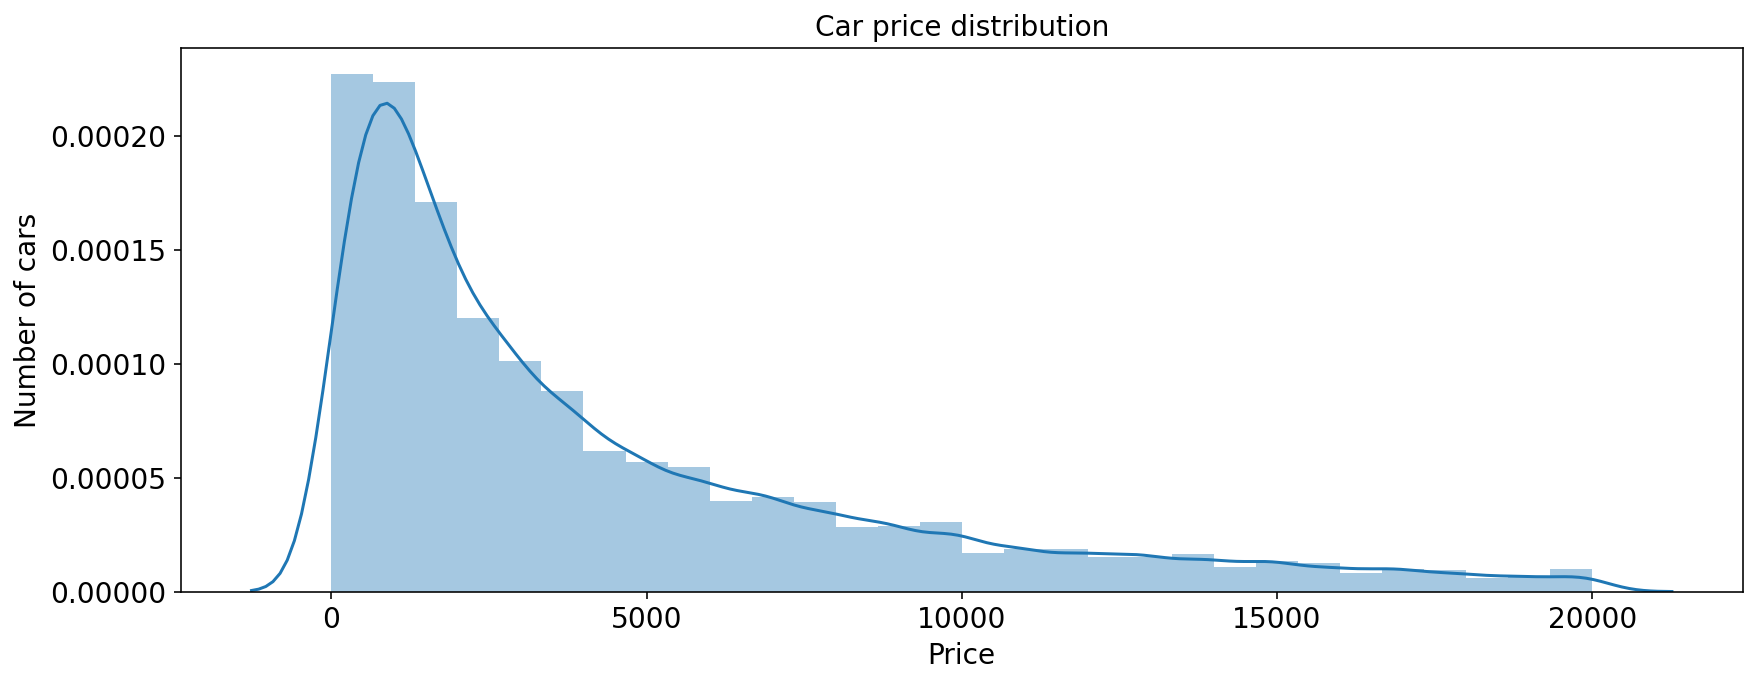

In [16]:
drawDistributionPlot(raw_autos, 'Price', "Car price distribution", "Price", "Number of cars")

We observe that as the price increases, the number of models decreases. Most values in the range from 0 to ~2500 euros. 

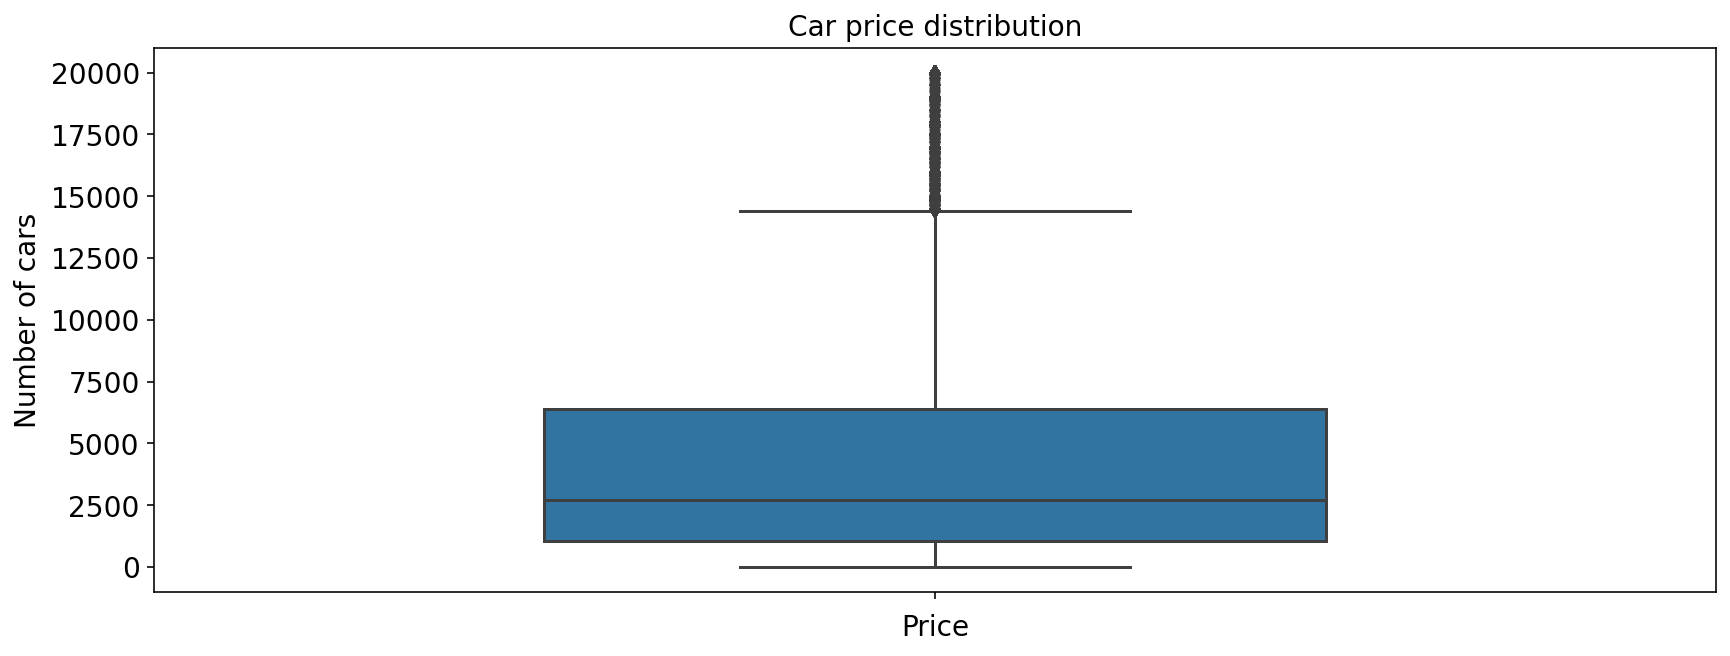

In [17]:
drawBoxPlot(raw_autos, 'Price', "Car price distribution", "Price", "Number of cars",True)

Let's see how many cars have a price over 15 thousand euros.

In [18]:
raw_autos_price_greater_15 = raw_autos.query('Price > 15000')
raw_autos_price_greater_15.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0.000,66954.000,2016-04-07 01:46:50
14,2016-03-21 12:57:01,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no,2016-03-21 00:00:00,0.000,4177.000,2016-04-06 07:45:42
33,2016-03-25 21:48:47,18000,sedan,2007,auto,218,3er,20000,5,petrol,bmw,no,2016-03-25 00:00:00,0.000,39179.000,2016-04-07 04:45:21
172,2016-03-07 12:38:19,19750,convertible,2006,manual,305,mustang,50000,7,petrol,ford,no,2016-03-07 00:00:00,0.000,38350.000,2016-03-12 20:18:29
179,2016-03-08 20:58:31,16449,wagon,2015,auto,110,fabia,10000,8,petrol,skoda,no,2016-03-08 00:00:00,0.000,95502.000,2016-04-06 01:17:03


Let's see number of values.

In [19]:
print(f'Number of cars with a price over 15 thousand euros: {len(raw_autos_price_greater_15)}')
print(f'Share of cars with a price over 15 thousand euros of the total number of: {round(len(raw_autos_price_greater_15) / len(raw_autos) * 100, 2)}%')

Number of cars with a price over 15 thousand euros: 6078
Share of cars with a price over 15 thousand euros of the total number of: 4.27%


Normal values fall into the interquartile range, outside the range there are outliers. After 15 thousand euros, there are outliers. 4.2% outliers, not so much. We leave them to the Machine Learning model to determine these cases.

Let's see which cars have a price of 0 euro.

In [20]:
raw_autos_price_zero = raw_autos.query('Price == 0')
raw_autos_price_zero.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0.000,19348.000,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0.000,56412.000,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0.000,21698.000,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0.000,37520.000,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0.000,27432.000,2016-03-12 23:47:10


In [21]:
print(f'Number of cars with a price of 0 euros: {len(raw_autos_price_zero)}')
print(f'Share of cars with a price of 0 euros from the total number: {round(len(raw_autos_price_zero) / len(raw_autos) * 100, 2)}%')

Number of cars with a price of 0 euros: 4392
Share of cars with a price of 0 euros from the total number: 3.08%


3.04% share of cars with a price of 0 euros. I assume that either this is a bug in the system, which should be reported to the developers or manager. I think we will remove objects with a price of 0 euros at the preprocessing stage of data.

### Mileage

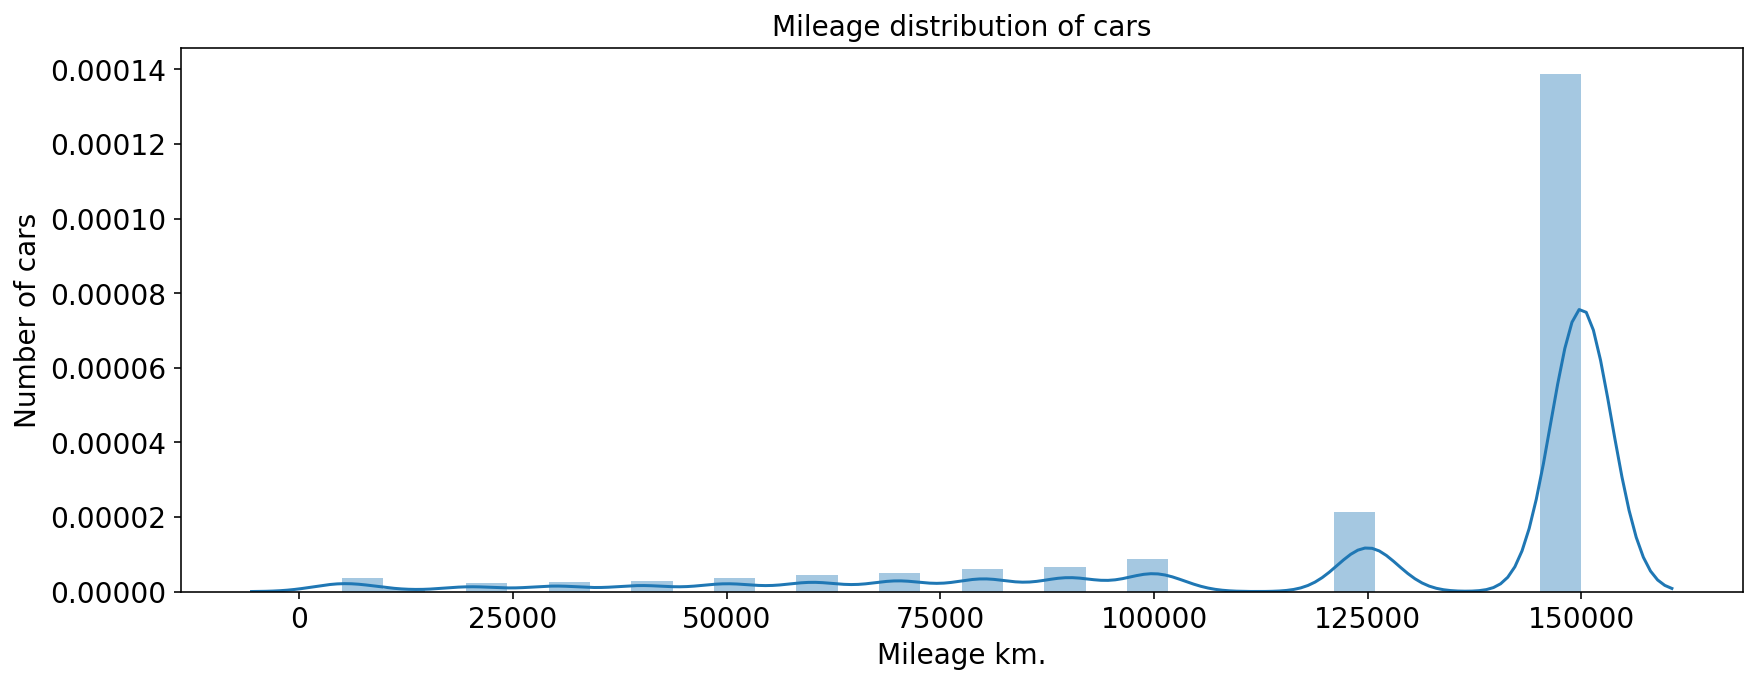

In [22]:
drawDistributionPlot(raw_autos, "Kilometer", "Mileage distribution of cars", "Mileage km.", "Number of cars")

Note that most cars have mileage of 140-150 thousand km. Is it an error in the system? Probably, the maximum value that can be set was 150 thousand km and no more. We should inform the management about the error.

### Power

Let's look at cars with 0 hp

In [23]:
raw_autos_power_zero = raw_autos.query('Power == 0')

In [24]:
raw_autos_power_zero.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0.000,70435.000,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0.000,24148.000,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0.000,44145.000,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0.000,46483.000,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0.000,56412.000,2016-03-27 17:43:34


In [25]:
print(f'Number of cars with 0 hp: {len(raw_autos_power_zero)}')
print(f'Share of cars with 0 hp of the total number of cars: {round(len(raw_autos_power_zero) / len(raw_autos) * 100, 2)}%')

Number of cars with 0 hp: 16190
Share of cars with 0 hp of the total number of cars: 11.37%


The share is 11.35%. This is most likely a system error. It is necessary to report this error to the management. We should preprocess such data. Let's look at the car with the maximum value in power.

In [26]:
raw_autos_power_2000 = raw_autos.query('Power == 20000')

In [27]:
raw_autos_power_2000

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


Most likely the user made a mistake in the field of vehicle power during registration.

### Registration year

In [28]:
raw_autos.query('RegistrationYear == 1000').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
16062,2016-03-29 23:42:16,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29 00:00:00,0.000,47166.000,2016-04-06 10:44:58
53577,2016-03-20 11:44:28,330,NaN,1000,NaN,0,polo,5000,0,NaN,volkswagen,NaN,2016-03-20 00:00:00,0.000,45259.000,2016-04-04 08:17:15
55605,2016-03-10 19:50:17,500,NaN,1000,NaN,0,NaN,5000,0,NaN,citroen,yes,2016-03-10 00:00:00,0.000,24811.000,2016-04-06 03:45:53
60017,2016-03-10 12:38:01,80,NaN,1000,NaN,0,NaN,5000,0,NaN,volkswagen,NaN,2016-03-10 00:00:00,0.000,93107.000,2016-04-07 04:45:57
66198,2016-03-08 14:50:20,1300,NaN,1000,auto,0,NaN,5000,6,petrol,sonstige_autos,NaN,2016-03-08 00:00:00,0.000,13156.000,2016-03-17 08:17:42


Well, this is definitely bad data. Let's remove them at the preprocessing stage.

In [29]:
raw_autos.query('RegistrationYear == 9999').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15147,2016-03-14 00:52:02,0,NaN,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-13 00:00:00,0.000,32689.000,2016-03-21 23:46:46
17271,2016-03-23 16:43:29,700,NaN,9999,NaN,0,other,10000,0,NaN,opel,NaN,2016-03-23 00:00:00,0.000,21769.000,2016-04-05 20:16:15
28390,2016-04-05 08:57:08,799,NaN,9999,NaN,0,3er,10000,4,petrol,bmw,NaN,2016-04-05 00:00:00,0.000,72116.000,2016-04-07 12:17:50
28965,2016-04-04 22:54:47,18000,NaN,9999,NaN,0,a_klasse,10000,0,petrol,mercedes_benz,NaN,2016-04-04 00:00:00,0.000,51379.000,2016-04-07 02:44:52
29426,2016-03-23 21:52:25,7999,NaN,9999,NaN,0,kaefer,10000,0,NaN,volkswagen,NaN,2016-03-23 00:00:00,0.000,47638.000,2016-04-06 03:46:40


## Summary

354369 objects in the dataframe. 16 columns. Most of the columns are of type *object*. The number of objects in each column is different. We have missing values. Hence, it is necessary to preprocess the data. Some columns will be unnecessary in the construction of models, such as: *DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen*. There are abnormal values in the columns: *RegistrationYear, Power, Kilometer* There are also zero values: *NumberOfPictures, Price* and missing values in *VehicleType, Model, FuelType, NotRepaired* columns. The data is raw, we need to preprocess it carefully. Also, we have date columns, we need to convert them to the correct *datetime* data type. We need:
1. Preprocess the data
2. Train different models
3. Analyze the speed and accuracy of the models

---

<a id="dataPreprocessing"></a>
# Stage 2 - Data preprocessing

Let's fix our first problems. We will handle columns and missing values, duplicates, abnormal values, and replace data types. Also, we will remove extra features.

<a id="columnsProcessing"></a>
### Column processing

Let's convert all column names to lower case.

In [30]:
def snake_case(s):
    """
    Converting strings from camelCase to snake_case.
    s - column name
    """
    return ''.join('_' + c.lower()
                   if all([i != 0,
                           c.isupper(),
                           s[i - 1].islower()])
                   else c.lower()
                   for i, c in enumerate(s))

In [31]:
# Convert columns to snake_case
raw_autos.columns = map(snake_case, raw_autos.columns)
raw_autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

<a id="removeColumns"></a>
## Column removing

Let's remove unnecessary columns: *DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen*. 

In [32]:
raw_autos = raw_autos.drop(['date_crawled','date_created' ,'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
raw_autos.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


<a id="missingValues"></a>
## Missing values

Let's see how many missing values are in the data. 

In [33]:
raw_autos.isna().sum()

price                     0
vehicle_type          14926
registration_year         0
gearbox                7930
power                     0
model                  7900
kilometer                 0
registration_month        0
fuel_type             13250
brand                     0
not_repaired          28660
dtype: int64

We have missing values in the following columns: *vehicle_type, gearbox, model, fuel_type, not_repaired*.

Create a copy of the dataframe

In [34]:
raw_autos_copy = raw_autos.copy()

Let's remove the missing values.

In [35]:
raw_autos_copy = raw_autos_copy.dropna(subset=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired'])
raw_autos_copy.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
dtype: int64

In [36]:
print(f'Number of objects before removing missing values: {len(raw_autos)}')
print(f'Number of objects after deleting missing values: {len(raw_autos_copy)}')
deleted_obj = len(raw_autos) - len(raw_autos_copy)
print(f'Number of objects deleted: {deleted_obj}')
print(f'Share of deleted objects: {round(deleted_obj / len(raw_autos) * 100, 2)}%')

Number of objects before removing missing values: 142387
Number of objects after deleting missing values: 98845
Number of objects deleted: 43542
Share of deleted objects: 30.58%


About 30% of the objects have been deleted. Let's try to recover the data.

Let's write a function that will output the number of rows with missing values.

In [37]:
def checkMissingValues(columnName,df):
    print(columnName,"check for missing values, the number of rows with a missing value: ",len(df[df[columnName].isna()]))

### Vehicle Type

To avoid data distortion, I suggest filling in the missing values of "unknown_type".

In [38]:
raw_autos['vehicle_type'] = raw_autos.vehicle_type.fillna("unknown_type")

In [39]:
checkMissingValues('vehicle_type', raw_autos)

vehicle_type check for missing values, the number of rows with a missing value:  0


### Gearbox

Let's look at the unique values in the *gearbox* column.

In [40]:
raw_autos['gearbox'].value_counts()

manual    107924
auto       26533
Name: gearbox, dtype: int64

Выведем распределение

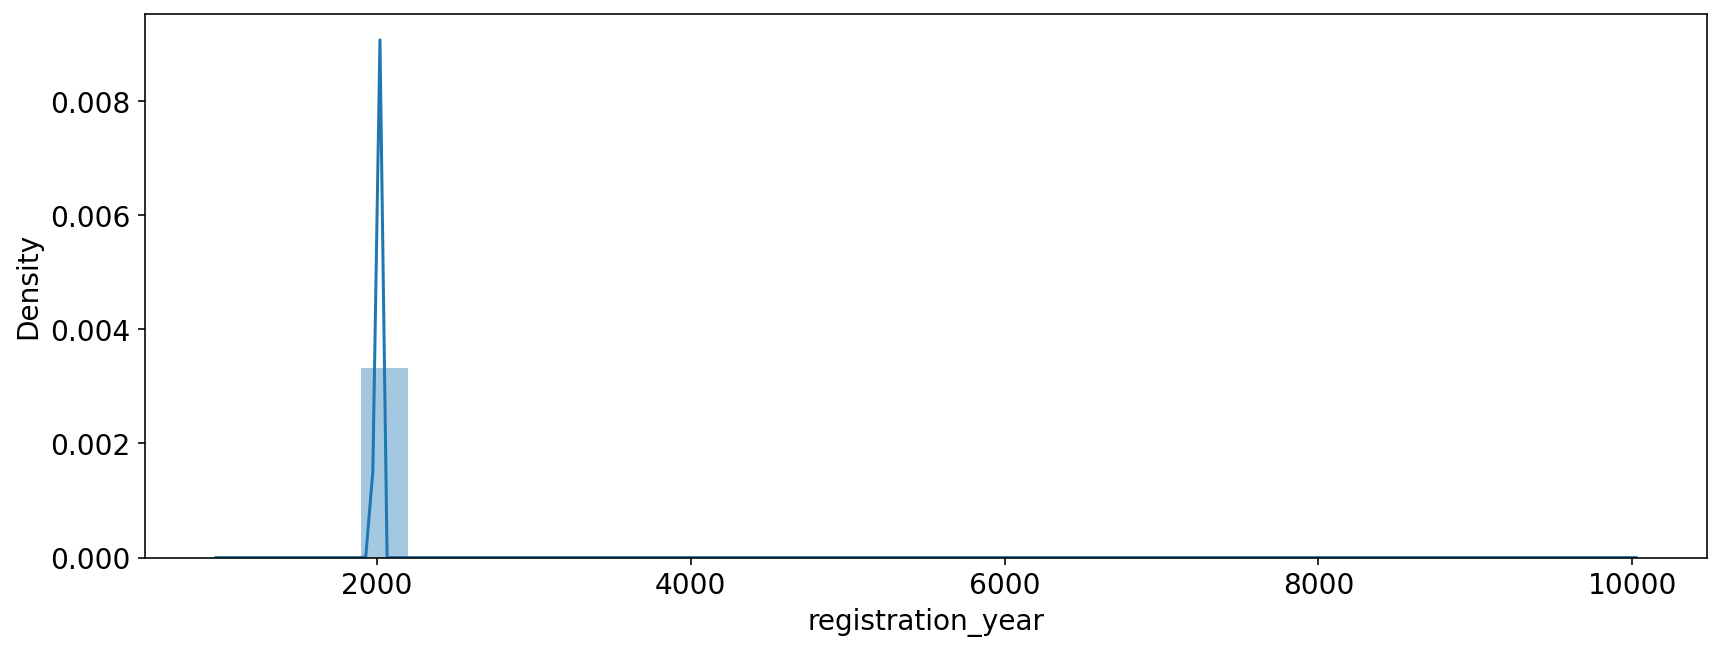

In [41]:
# KDE plot
plt.figure(figsize=(14,5))
plot  = sns.distplot(raw_autos['registration_year'],bins=30, kde=True)
plt.show()

Let's take an appropriate interval

In [42]:
raw_autos_copy = raw_autos.query('registration_year > 1900 and registration_year < 2020')

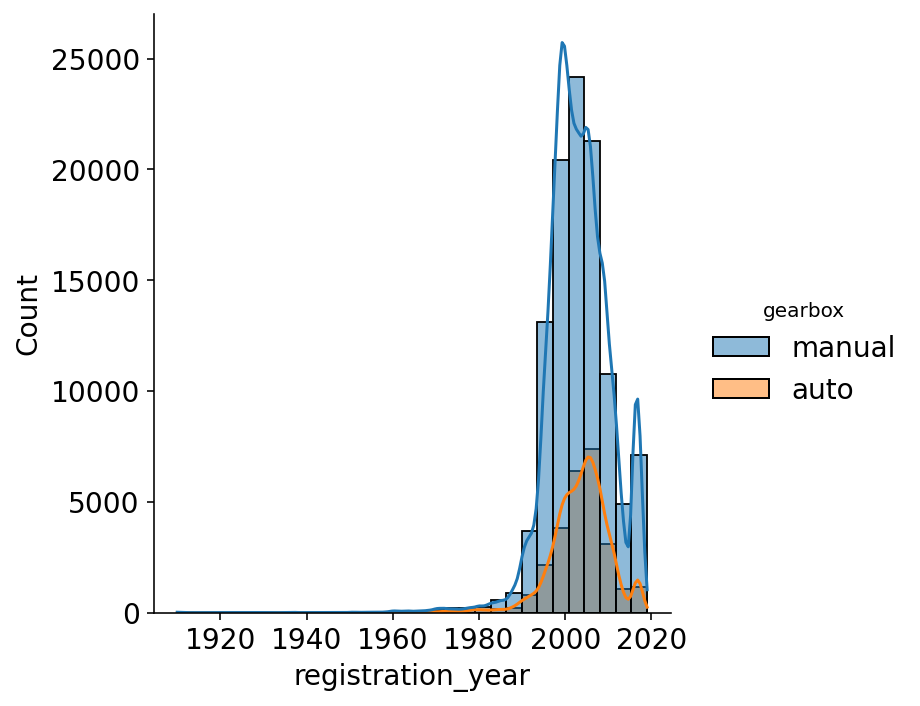

In [43]:
sns.displot(data = raw_autos_copy, x='registration_year',bins=30, kde=True, hue='gearbox')
plt.show()

The first automatic transmission was installed in 1947. We can safely assume that cars before 1947 had a manual transmission

In [44]:
raw_autos.loc[raw_autos['registration_year'] < 1947, 'gearbox'] = raw_autos.loc[raw_autos['registration_year'] < 1947, 'gearbox'].fillna("manual")

To avoid distortions in the data, let's fill in the remaining missing values - "unknown_gearbox". 

In [45]:
raw_autos['gearbox'] = raw_autos.gearbox.fillna("unknown_gearbox")

In [46]:
checkMissingValues('gearbox', raw_autos)

gearbox check for missing values, the number of rows with a missing value:  0


### Model

To avoid distortions in the data, let's fill in the missing value - "unknown_model". 

In [47]:
raw_autos['model'] = raw_autos.model.fillna("unknown_model")

In [48]:
checkMissingValues('model', raw_autos)

model check for missing values, the number of rows with a missing value:  0


### Fuel type

In [49]:
raw_autos['fuel_type'] = raw_autos.fuel_type.fillna("unknown_fuel_type")

In [50]:
checkMissingValues('fuel_type', raw_autos)

fuel_type check for missing values, the number of rows with a missing value:  0


### Not repaired

I suggest replacing the missing values of the *not_repaired* column with the value *unknown_repair_status*. 

In [51]:
raw_autos['not_repaired'] = raw_autos['not_repaired'].fillna('unknown_repair_status')

In [52]:
checkMissingValues('not_repaired', raw_autos)

not_repaired check for missing values, the number of rows with a missing value:  0


In [53]:
raw_autos.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
dtype: int64

<a id="duplicateValues"></a>
## Duplicate values

We need to check for the presence of duplicates. If there are duplicates - delete them, otherwise our study can lead to incorrect results. Let's use the set of methods *duplicated()* and *sum()*.

In [54]:
print(f'Number of duplicates: {raw_autos.duplicated().sum()}')
print(f'Share of duplicates in dataset: {round(raw_autos.duplicated().sum() / len(raw_autos),2)}%')

Number of duplicates: 5318
Share of duplicates in dataset: 0.04%


27543 Duplicates. We will have to remove them.

In [55]:
raw_autos = raw_autos.drop_duplicates().reset_index(drop=True)

<a id="abnormalValues"></a>
## Abnormal values

Let's handle the abnormal values. Earlier in the data overview stage, we highlighted that some columns have abnormal values.

### Registration Year

We noticed a maximum value of 9999 and a minimum value of 1000.

In [56]:
reg_year_1000 = raw_autos.query('registration_year == 1000')
reg_year_1000.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
15962,190,unknown_type,1000,manual,0,mondeo,5000,0,unknown_fuel_type,ford,unknown_repair_status
52637,330,unknown_type,1000,manual,0,polo,5000,0,unknown_fuel_type,volkswagen,unknown_repair_status
54605,500,unknown_type,1000,manual,0,unknown_model,5000,0,unknown_fuel_type,citroen,yes
58886,80,unknown_type,1000,manual,0,unknown_model,5000,0,unknown_fuel_type,volkswagen,unknown_repair_status
64859,1300,unknown_type,1000,auto,0,unknown_model,5000,6,petrol,sonstige_autos,unknown_repair_status


In [57]:
reg_year_9999 = raw_autos.query('registration_year == 9999')
reg_year_9999.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
15063,0,unknown_type,9999,unknown_gearbox,0,unknown_model,10000,0,unknown_fuel_type,sonstige_autos,unknown_repair_status
17155,700,unknown_type,9999,unknown_gearbox,0,other,10000,0,unknown_fuel_type,opel,unknown_repair_status
28086,799,unknown_type,9999,unknown_gearbox,0,3er,10000,4,petrol,bmw,unknown_repair_status
28648,18000,unknown_type,9999,unknown_gearbox,0,a_klasse,10000,0,petrol,mercedes_benz,unknown_repair_status
29101,7999,unknown_type,9999,unknown_gearbox,0,kaefer,10000,0,unknown_fuel_type,volkswagen,unknown_repair_status


In [58]:
print(f'Number of cars with 1000 year registration: {len(reg_year_1000)}')
print(f'Number of cars with 9999 registration: {len(reg_year_9999)}')

Number of cars with 1000 year registration: 16
Number of cars with 9999 registration: 9


Consequently, let's filter out the cars with registration from 1901 to 2016.

In [59]:
raw_autos_upd = raw_autos.query('registration_year > 1900 and registration_year < 2017').reset_index(drop=True)

### Power

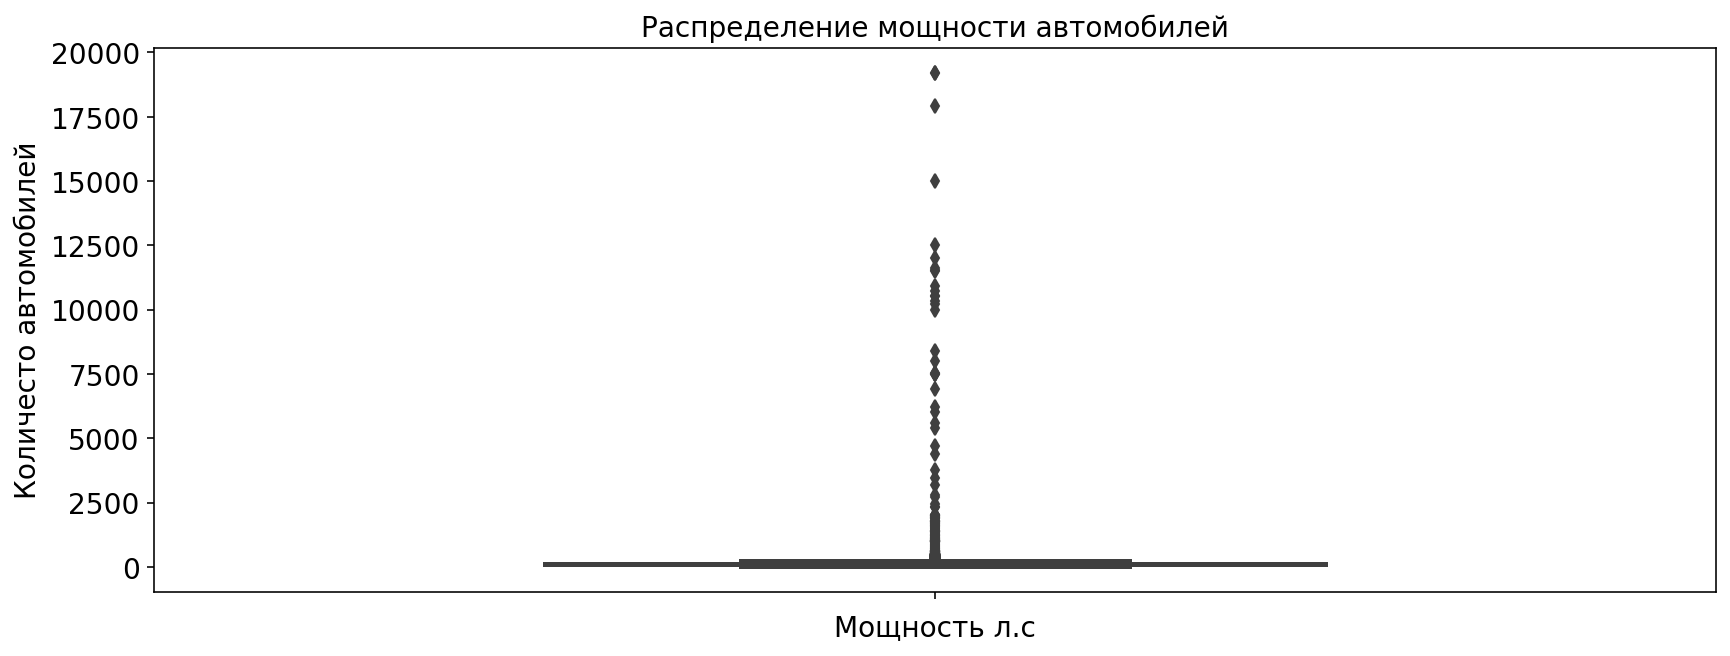

In [60]:
drawBoxPlot(raw_autos_upd, 'power', "Распределение мощности автомобилей", "Мощность л.с", "Количесто автомобилей",True)

Let's look at the number of rows where power < 10 and how many machines have power > 700.

In [61]:
num_of_cars_power_10 = len(raw_autos_upd.query('power < 10'))
num_of_cars_power_greater_500= len(raw_autos_upd.query('power > 700'))
print(f'Number of rows with power < 10: {num_of_cars_power_10}')
print(f'Number of rows with power > 700: {num_of_cars_power_greater_500}')

Number of rows with power < 10: 14096
Number of rows with power > 700: 115


Let's look at the lines where power > 700. Maybe these are some supercars? 

In [62]:
raw_autos_upd.query('power > 700').sort_values(by='price', ascending=False).head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
78816,18550,sedan,2013,manual,1288,c_klasse,90000,11,gasoline,mercedes_benz,no
42513,15800,convertible,2014,auto,10218,fortwo,30000,3,petrol,smart,unknown_repair_status
44277,15000,coupe,2013,auto,751,unknown_model,10000,1,petrol,sonstige_autos,no
97255,11399,unknown_type,1995,manual,1995,unknown_model,150000,12,gasoline,bmw,unknown_repair_status
113920,11000,coupe,2002,manual,800,unknown_model,150000,11,unknown_fuel_type,opel,unknown_repair_status
23923,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no
124588,10500,wagon,2007,auto,2331,a6,150000,10,gasoline,audi,no
60890,10000,wagon,2008,manual,2005,sprinter,150000,1,gasoline,mercedes_benz,no
105960,9999,sedan,2006,manual,19211,1er,125000,0,gasoline,bmw,unknown_repair_status
124679,9999,coupe,1990,auto,2789,s_klasse,150000,6,petrol,mercedes_benz,unknown_repair_status


There were no supercars, so we take the interval 10 < power < 700

In [63]:
raw_autos_upd = raw_autos.query('power > 10 and power < 700')

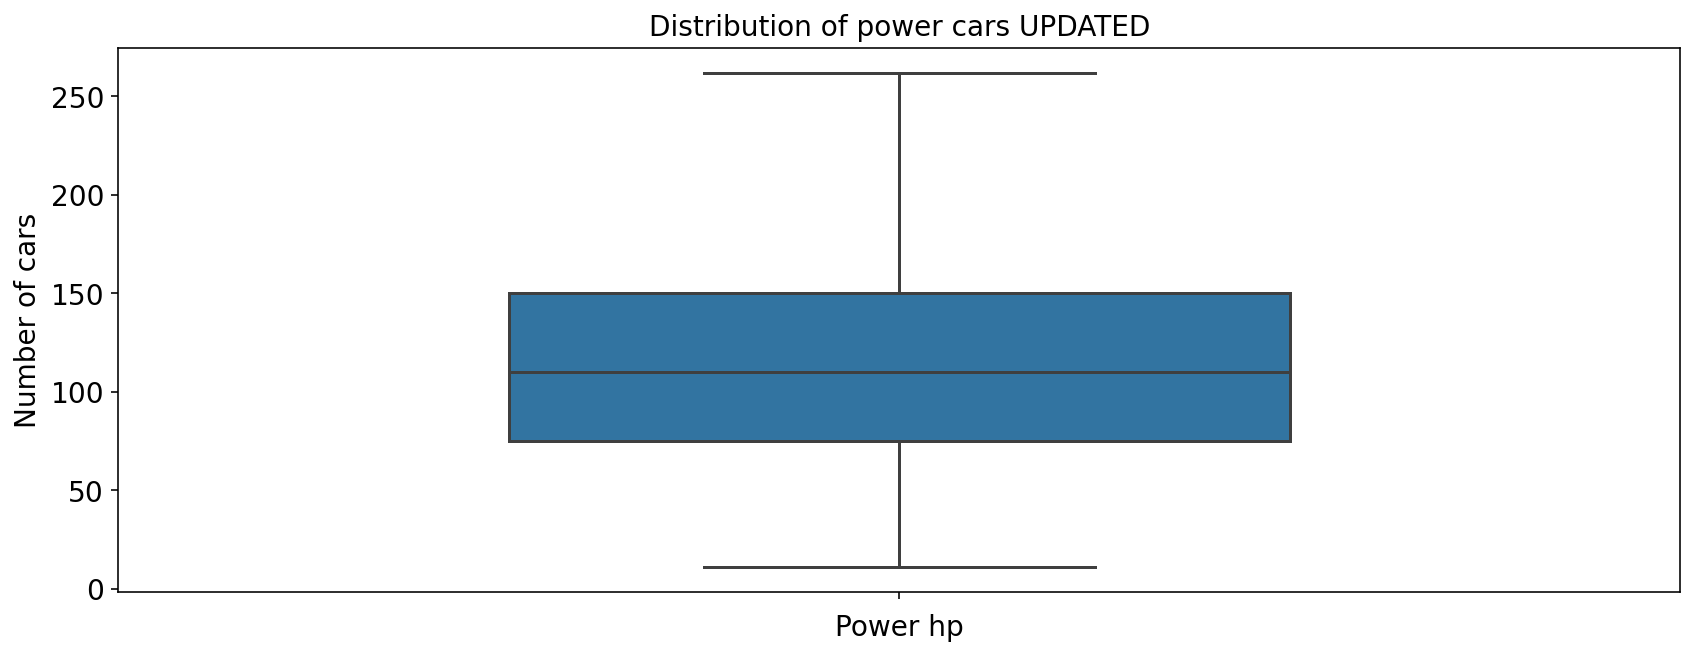

In [64]:
drawBoxPlot(raw_autos_upd, 'power', "Distribution of power cars UPDATED", "Power hp", "Number of cars")

### Kilometer

In [65]:
raw_autos_upd.describe()['kilometer']

count   121365.000
mean    128510.897
std      36736.908
min       5000.000
25%     125000.000
50%     150000.000
75%     150000.000
max     150000.000
Name: kilometer, dtype: float64

In average - 128 thousands of kilometers. Notice that 50% and 70% percentile have the maximum value - 150 thousands of kilometers. Do we have an error in recording data? Maybe in the form, there is a fixed maximum value for the input - 150 thousands of kilometers? 

### Registration Month

In [66]:
raw_autos_upd.describe()['registration_month']

count   121365.000
mean         5.926
std          3.614
min          0.000
25%          3.000
50%          6.000
75%          9.000
max         12.000
Name: registration_month, dtype: float64

Note the minimum and maximum values, 0 and 12, respectively. A discrepancy in the number of months.

I think we do not need this column in building the model. Thus, we are not going to preprocess this column

### Price

In [67]:
raw_autos_upd.describe()['price']

count   121365.000
mean      4706.541
std       4604.589
min          0.000
25%       1250.000
50%       2999.000
75%       6850.000
max      20000.000
Name: price, dtype: float64

We have 0 values.

In [68]:
raw_autos_upd.query('price < 2').head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
59,1,suv,1994,manual,286,unknown_model,150000,11,unknown_fuel_type,sonstige_autos,unknown_repair_status
89,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes
231,0,wagon,2001,manual,115,mondeo,150000,0,unknown_fuel_type,ford,unknown_repair_status


In [69]:
print(f'Number of cars with price 0: {len(raw_autos_upd.query("price == 0"))}')

Number of cars with price 0: 2623


Filter cars which price is equal to 0 euro

In [70]:
raw_autos_upd = raw_autos_upd.query('price > 0').reset_index(drop=True)

In [71]:
raw_autos_upd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118742 entries, 0 to 118741
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               118742 non-null  int64 
 1   vehicle_type        118742 non-null  object
 2   registration_year   118742 non-null  int64 
 3   gearbox             118742 non-null  object
 4   power               118742 non-null  int64 
 5   model               118742 non-null  object
 6   kilometer           118742 non-null  int64 
 7   registration_month  118742 non-null  int64 
 8   fuel_type           118742 non-null  object
 9   brand               118742 non-null  object
 10  not_repaired        118742 non-null  object
dtypes: int64(5), object(6)
memory usage: 10.0+ MB


Write a function which:
1. Check for missing data
2. Check for duplicate values
4. Check appropriate types: float64, int64, object, datetime64

In [72]:
def get_preprocessed_data(raw_data):
    """
    Function checks dataframe. Returns preprocessed data for model training 
    raw_data - data to check
    """
    # check data
    assert raw_data.isna().sum().sum() == 0, 'There should not be missing data!'
    assert raw_data.select_dtypes(exclude=[np.float64, np.int64, np.object, np.datetime64]).size == 0, 'Type of data needs to be one of the following: float64, int64, object, datetime64!'
    assert raw_data.duplicated().sum().sum() == 0, 'There should not be duplicate values'
    print('Data is valid!')
    # creating a copy of a data
    preprocessed_data = raw_data.copy()
    
    return preprocessed_data

In [73]:
autos = get_preprocessed_data(raw_autos_upd)

Data is valid!


<a id="encoding"></a>
## Encoding 

Columns *vehicle_type*, *model*, *fuel_type*, *brand*, *not_repaired* - caterogical features. We need to transform them into numerical features. Let's use one of the encoding techniques [Ordinal Encoding](https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/), since we have many categorical features.

In [74]:
# create an object 
encoder = OrdinalEncoder()

We will use function [fit_transform()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder.fit_transform), which will take the list of categorical features and transform them. We will create a new dataframe with transformed features

In [75]:
autos_ordinal = autos.copy()
autos_ordinal.loc[:,['vehicle_type', 'model', 'fuel_type', 'brand', 'not_repaired','gearbox']] = encoder.fit_transform(autos_ordinal.loc[:,['vehicle_type', 'model', 'fuel_type', 'brand', 'not_repaired','gearbox']])
autos_ordinal.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,18300,2.000,2011,1.000,190,227.000,125000,5,2.000,1.000,2.000
1,9800,6.000,2004,0.000,163,117.000,125000,8,2.000,14.000,1.000
2,1500,5.000,2001,1.000,75,116.000,150000,6,6.000,38.000,0.000
3,3600,5.000,2008,1.000,69,101.000,90000,7,2.000,31.000,0.000
4,650,4.000,1995,1.000,102,11.000,150000,10,6.000,2.000,2.000


<a id="dataSeparation"></a>
## Data separation

We need to check the accuracy of the model. Thus, we have to split the data for cross-validation. We will split the original data into 2 samples: training and test in ratio (*75/25*). Validation sample will be generated in the cross-validation.

First, let's write a function for target and features separation.

In [76]:
def target_features_split(data,column):
    """
    Function separates target and features. It returns 1) target, 2) features
    data - data that needs to be splitted 
    column - target 
    """
    return data[column], data.drop(column,axis=1)

Fix ***random_state***

In [77]:
random_state_value = 42

In [78]:
target, features = target_features_split(autos_ordinal, 'price')

In sklearn, there is a functon for sample splitting *train_test_split()*. We will write a functon for sample splitting and displaying the sizes of resulted samples, to avoid errors.

In [79]:
def sampleSize(original, train, test):
    """
    Function for displaying the sizes of resulted samples
    original - original data
    train - training sample
    test - test sample
    """
    print(f'Size of the original data: {len(original)}')
    print(f'Size of the training sample:  {len(train)}')
    print(f'Size of the test sample: {len(test)}')

In [80]:
def cross_val_splitting_data(target,features):
    """
    Function for splitting data into training and test samples. It returns targets, and features of training and test samples
    target
    features
    """
    features_train, features_test, target_train, target_test = train_test_split(features, target,random_state=random_state_value,test_size=0.25)
    # checks sizes of samples
    sampleSize(features,features_train,features_test)
    return features_train,target_train, features_test, target_test

In [81]:
features_train_cross, target_train_cross, features_test_cross, target_test_cross = cross_val_splitting_data(target, features)

Size of the original data: 118742
Size of the training sample:  89056
Size of the test sample: 29686


<a id="standardization"></a>
## Standardization

Our features have different scales. We need to convert them into 1 scale.

We will use a separate structure of library *sklearn* for standardization - *Standard Scaler*.

In [82]:
def crossValStandardScaling(features_train, features_test):
    """
    Функция для стандартизации данных. Возвращает стандартизированые данные из обучающей и тестовой выборки
    Function for data standardization. It returns standardized data from training and test samples
    features_train - features of training sample
    features_test - features of test sample
    """
    features_train_copy = features_train.copy()
    features_test_copy = features_test.copy()
    # Initialize scaler
    scaler = StandardScaler()
    # Numerical columns
    numeric = ['power','registration_year', 'kilometer']
    # setting up scaler on training sample
    scaler.fit(features_train_copy.loc[:,numeric])
    # transform samples with trained scaler
    features_train_copy.loc[:,numeric] = scaler.transform(features_train_copy.loc[:,numeric])
    features_test_copy.loc[:,numeric] = scaler.transform(features_test_copy.loc[:,numeric])
    
    return features_train_copy, features_test_copy

In [83]:
features_train_cross, features_test_cross = crossValStandardScaling(features_train_cross, features_test_cross)

## Summary

At this stage, we: 
1. Processed columns. All columns are converted to lower case
2. Processed missing data
3. Applied encoding 
4. Removed extra columns 
5. Checked data with custom function. Data has been validated 
6. Splitted data for cross-validation: splitted data into 2 samples: training and test in ratio (*75/25*).
7. Standardized columns

Data is ready for training models.

<a id="MLmodelResearch"></a>
# Stage 3 - Machine Learning models research

At this stage, we need to do a ML models research and find the best model.

We will check some Regression models. Find the hyperparameters as well as check metric values: 
- RMSE (Root Mean Squared Error) 

We will keep track of machine learning models. We will create a list of models using a dictionary. Then from the dictionary we will convert the model table with all the metrics. 

In [84]:
ml_models_stats = dict()

Let's write a function to evaluate the models. 

In [85]:
def evaluate_model(model_name, model,training_time,features_test, target_test,features_train, target_train,parameters=None):
    """
    Function evaluates model on RMSE metric, adds model to the table with metrics and training time.
    model_name
    model 
    train_score - Accuracy on training sample
    features_test - test sample features
    target_test - test sample target
    parameters 
    """
    print(f'Evaluation of the model: {model_name}')
    if parameters:
        print(f'with parameters: {parameters}')
    print()
    predict_start = datetime.datetime.now()
    predicted_test = model.predict(features_test)
    predict_time = datetime.datetime.now() - predict_start
    # MSE 
    mse_test = mean_squared_error(target_test, predicted_test)
    # RMSE
    rmse_test = mse_test ** 0.5
    predicted_train = model.predict(features_train)
    # MSE 
    mse_train = mean_squared_error(target_train, predicted_train)
    # RMSE
    rmse_train = mse_train ** 0.5
    
    print(f'RMSE on training sample: {rmse_train}')
    print(f'RMSE on test sample: {rmse_test}')
    print(f'Training time: {training_time}')
    print(f'Prediciton time: {predict_time}')
    # add the model
    ml_models_stats[model_name] = {
        'name': model_name,
        'training_time': training_time,
        'predict_time':predict_time,
        'rmse_test':rmse_test,
        'rmse_train':rmse_train
    }
    print()
    print('Model has been successfully added!')

We will find parameters by using GridSearchCV, that has cross-validation

Make an RMSE scorer for GridSearch

In [86]:
def rmse(target,predictions):
    """
    Function to calculate RMSE
    target 
    predictions
    """
    mse = mean_squared_error(target, predictions)
    return mse ** 0.5

In [87]:
# create scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

Linear Regression model will not work with ordinal encoding. Thus, we will not use it and start with Decision Tree. We would have use OHE encoding, however, we have many categorical features. OHE encoding will create a lot of columns, which will make it difficult to train model.

### Decision Tree

In [88]:
start = datetime.datetime.now()
# create a model
decision_tree_model = DecisionTreeRegressor()
# parameters
decision_parameters = {
              "max_depth": range(1, 11),
              "min_samples_leaf": range(1, 11)
}

decision_grid =  RandomizedSearchCV(estimator=decision_tree_model, param_distributions=decision_parameters, cv=5,scoring=rmse_scorer, n_iter = 20, n_jobs=-1)
decision_grid.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start

In [89]:
evaluate_model('Decision Tree', decision_grid,training_time,features_test_cross, target_test_cross,features_train_cross,target_train_cross,decision_grid.best_params_)

Evaluation of the model: Decision Tree
with parameters: {'min_samples_leaf': 9, 'max_depth': 10}

RMSE on training sample: 1887.86156967912
RMSE on test sample: 2032.5611022117735
Training time: 0:00:15.255814
Prediciton time: 0:00:00.011354

Model has been successfully added!


Decision Tree trained quickly. It makes mistakes on ~2032 euro.

### Random Forest

In [90]:
start = datetime.datetime.now()
# create a model
random_forest_model = RandomForestRegressor()
# parameters
gs_params = {
    'max_depth': range(1, 21),
    'n_estimators':range(1,61,10)
}
# create a RandomizedSearchCV, specifying number of iterations
forest_rs = RandomizedSearchCV(estimator=random_forest_model,param_distributions=gs_params,scoring=rmse_scorer,cv=5,n_iter = 20,n_jobs=-1)
# train the model
forest_rs.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start

In [91]:
evaluate_model('Random Forest', forest_rs,training_time,features_test_cross, target_test_cross,features_train_cross,target_train_cross,forest_rs.best_params_)

Evaluation of the model: Random Forest
with parameters: {'n_estimators': 51, 'max_depth': 15}

RMSE on training sample: 1154.4416372766434
RMSE on test sample: 1755.557325128913
Training time: 0:03:44.685285
Prediciton time: 0:00:00.370468

Model has been successfully added!


It took 11 minutes for Random Forest to train. However, model showed good results on training and test samples. On test sample, model makes mistakes on 1755 euro.

### XGBoost

In [92]:
start = datetime.datetime.now()
# parameters
xgb_params = {
    "max_depth": range(3, 10,2),
    "min_child_weight": range(1,6,2)
}
# create model 
xgb = xgb.XGBRegressor(nthread=-1) 
# create GridSearchCV
xgb_gs = GridSearchCV(xgb, xgb_params, scoring=rmse_scorer,n_jobs=-1)
# train model
xgb_gs.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start

[08:55:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [93]:
evaluate_model('XGBoost', xgb_gs,training_time,features_test_cross, target_test_cross,features_train_cross,target_train_cross,xgb_gs.best_params_)

Evaluation of the model: XGBoost
with parameters: {'max_depth': 9, 'min_child_weight': 5}

RMSE on training sample: 1338.3145546862652
RMSE on test sample: 1668.8386343676225
Training time: 0:06:10.068887
Prediciton time: 0:00:00.218077

Model has been successfully added!


XGBoost also showed good results on training and test samples. RMSE on test: 1615. However, it took 5 min to train the model.

### LightGBM

In [94]:
start = datetime.datetime.now()
lgb_params = {
    'objective': ['regression','binary'],
    'boosting_type' : ['dart','gbdt','goss'],
    'max_depth': [15,30],
    'num_leaves': [10,200,250]
}
lgb_reg = lgb.LGBMRegressor()
lgb_gs = GridSearchCV(lgb_reg, lgb_params,scoring=rmse_scorer,n_jobs=-1)
lgb_gs.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start

In [95]:
evaluate_model('LightGBM', lgb_gs,training_time,features_test_cross, target_test_cross,features_train_cross,target_train_cross,lgb_gs.best_params_)

Evaluation of the model: LightGBM
with parameters: {'boosting_type': 'gbdt', 'max_depth': 30, 'num_leaves': 250, 'objective': 'regression'}

RMSE on training sample: 1324.4240676868671
RMSE on test sample: 1652.228935282971
Training time: 0:03:03.830959
Prediciton time: 0:00:00.250325

Model has been successfully added!


Best result on sample test so far. Model mistakes on 1652 euro on test sample. In addition, model took 4 minutes to train.

### CatBoost

In [96]:
start = datetime.datetime.now()
catBoost_params = {
    'learning_rate': [1],
    'depth': [5, 6, 7, 8],
    'l2_leaf_reg': [1, 2, 3]
}
catBoost_reg = CatBoostRegressor(loss_function='RMSE',random_state=random_state_value,silent=True,eval_metric="RMSE")
catBoost_gs = GridSearchCV(catBoost_reg, catBoost_params,scoring=rmse_scorer,n_jobs=-1)
catBoost_gs.fit(features_train_cross,  target_train_cross)
training_time = datetime.datetime.now() - start

In [97]:
evaluate_model('CatBoost', catBoost_gs,training_time, features_test_cross, target_test_cross,features_train_cross,target_train_cross,catBoost_gs.best_params_)

Evaluation of the model: CatBoost
with parameters: {'depth': 5, 'l2_leaf_reg': 3, 'learning_rate': 1}

RMSE on training sample: 1268.8870388901782
RMSE on test sample: 1740.9737634003895
Training time: 0:18:42.548597
Prediciton time: 0:00:00.043162

Model has been successfully added!


20 minutes! Fortunately, model showed good results on test sample. RMSE on test sample: 1740

We need to do sanity check. Let's use Dummy model

### Dummy

In [98]:
start = datetime.datetime.now()
# create the model
dummy_model = DummyRegressor(strategy="constant", constant=target_train_cross.median())
# train the model
dummy_model.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start

In [99]:
evaluate_model('Dummy constant', dummy_model, training_time, features_test_cross, target_test_cross,features_train_cross,target_train_cross)

Evaluation of the model: Dummy constant

RMSE on training sample: 4941.014645537766
RMSE on test sample: 4954.99931074743
Training time: 0:00:00.002745
Prediciton time: 0:00:00.000306

Model has been successfully added!


### Summary

At this stage we made a research on Machine Learning models. We have tried many Regression models: Linear Regression, Decision Tree, Random Forest, XGboost, LightGBM, CatBoost. Let's proceed to model analysis.

<br>

<a id="resultsRearchModel"></a>
# Stage 4 - Model's speed and accuracy analysis

At this stage, we need to analyze the speed and accuracy of the models.

Business considers the following metrics: **accuracy, training time, prediction time**. Based on this metrics, we will find the best model.

Firstly, let's write a function that will plot the graphs to help with analysis.

In [100]:
def drawPlot(df,x_axis, y_axis, x_label, y_label,plot_title, order_by=None):
    """
    Function for plotting graphs 
    df - dataframe
    x_axis
    y_axis
    x_label - label for x axis
    y_label - label for y axis
    plot_title - title 
    order - column by which the order will be determined 
    """
    plt.title(plot_title)
    sns.barplot(x=x_axis,y=y_axis, data=df,order=df[order_by])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

Create the table from the models dictionary

In [101]:
ml_models = pd.DataFrame.from_dict(data=ml_models_stats, orient='index').reset_index(drop=True)
ml_models

,name,training_time,predict_time,rmse_test,rmse_train
0,Decision Tree,0 days 00:00:15.255814,0 days 00:00:00.011354,2032.561,1887.862
1,Random Forest,0 days 00:03:44.685285,0 days 00:00:00.370468,1755.557,1154.442
2,XGBoost,0 days 00:06:10.068887,0 days 00:00:00.218077,1668.839,1338.315
3,LightGBM,0 days 00:03:03.830959,0 days 00:00:00.250325,1652.229,1324.424
4,CatBoost,0 days 00:18:42.548597,0 days 00:00:00.043162,1740.974,1268.887
5,Dummy constant,0 days 00:00:00.002745,0 days 00:00:00.000306,4954.999,4941.015


Models that have passed the sanity check.

In [102]:
approved_models = ml_models.query("rmse_test < 4862.087")
approved_models

,name,training_time,predict_time,rmse_test,rmse_train
0,Decision Tree,0 days 00:00:15.255814,0 days 00:00:00.011354,2032.561,1887.862
1,Random Forest,0 days 00:03:44.685285,0 days 00:00:00.370468,1755.557,1154.442
2,XGBoost,0 days 00:06:10.068887,0 days 00:00:00.218077,1668.839,1338.315
3,LightGBM,0 days 00:03:03.830959,0 days 00:00:00.250325,1652.229,1324.424
4,CatBoost,0 days 00:18:42.548597,0 days 00:00:00.043162,1740.974,1268.887


All models passed sanity check

Convert prediction time in milliseconds

In [103]:
def milliseconds_from_timedelta(timedelta):
    """Convert to milliseconds from object timedelta"""
    return timedelta.total_seconds() * 1e3

In [105]:
approved_models['prediction_time_milliseconds'] = approved_models['predict_time'].apply(milliseconds_from_timedelta)

Convert training time in secods

In [106]:
def seconds_from_timedelta(timedelta):
    """Convert to seconds from object timedelta"""
    return timedelta.total_seconds()

In [107]:
approved_models['training_time_seconds'] = approved_models['training_time'].apply(seconds_from_timedelta)

Find the best model on RMSE metric on test sample.

,name,rmse_test
0,LightGBM,1652.229
1,XGBoost,1668.839
2,CatBoost,1740.974
3,Random Forest,1755.557
4,Decision Tree,2032.561


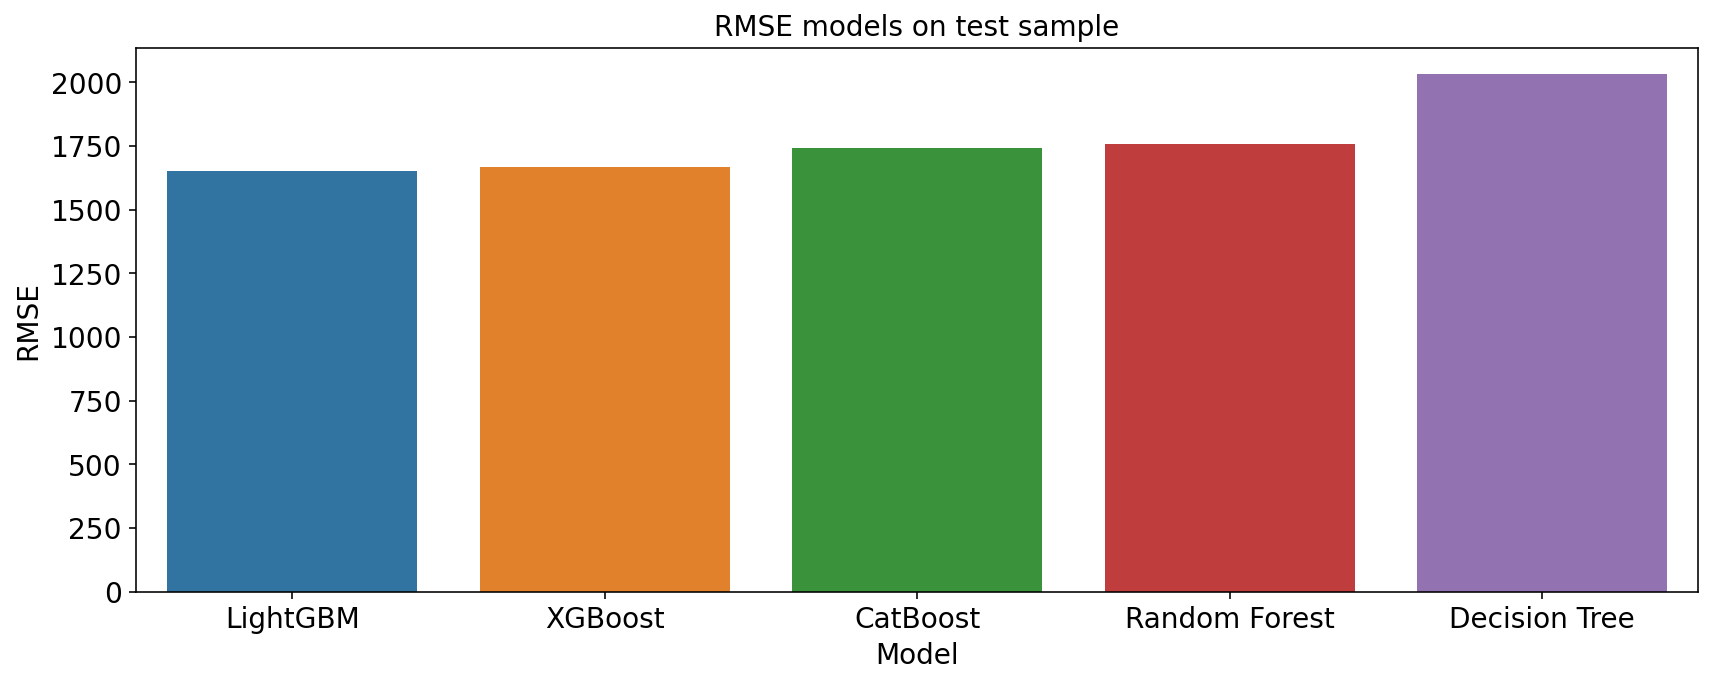

In [108]:
rmse_test_sorted = approved_models.sort_values(by='rmse_test',ascending=True).reset_index()
display(rmse_test_sorted[['name','rmse_test']])
drawPlot(rmse_test_sorted, 'name','rmse_test','Model','RMSE','RMSE models on test sample','name' )

LightGBM took first place with result - **1652.229**. XGBoost took 2nd place with result - **1668.839**

Find the model that has minimum training time (fastest on training)

,name,training_time
0,Decision Tree,0 days 00:00:15.255814
1,LightGBM,0 days 00:03:03.830959
2,Random Forest,0 days 00:03:44.685285
3,XGBoost,0 days 00:06:10.068887
4,CatBoost,0 days 00:18:42.548597


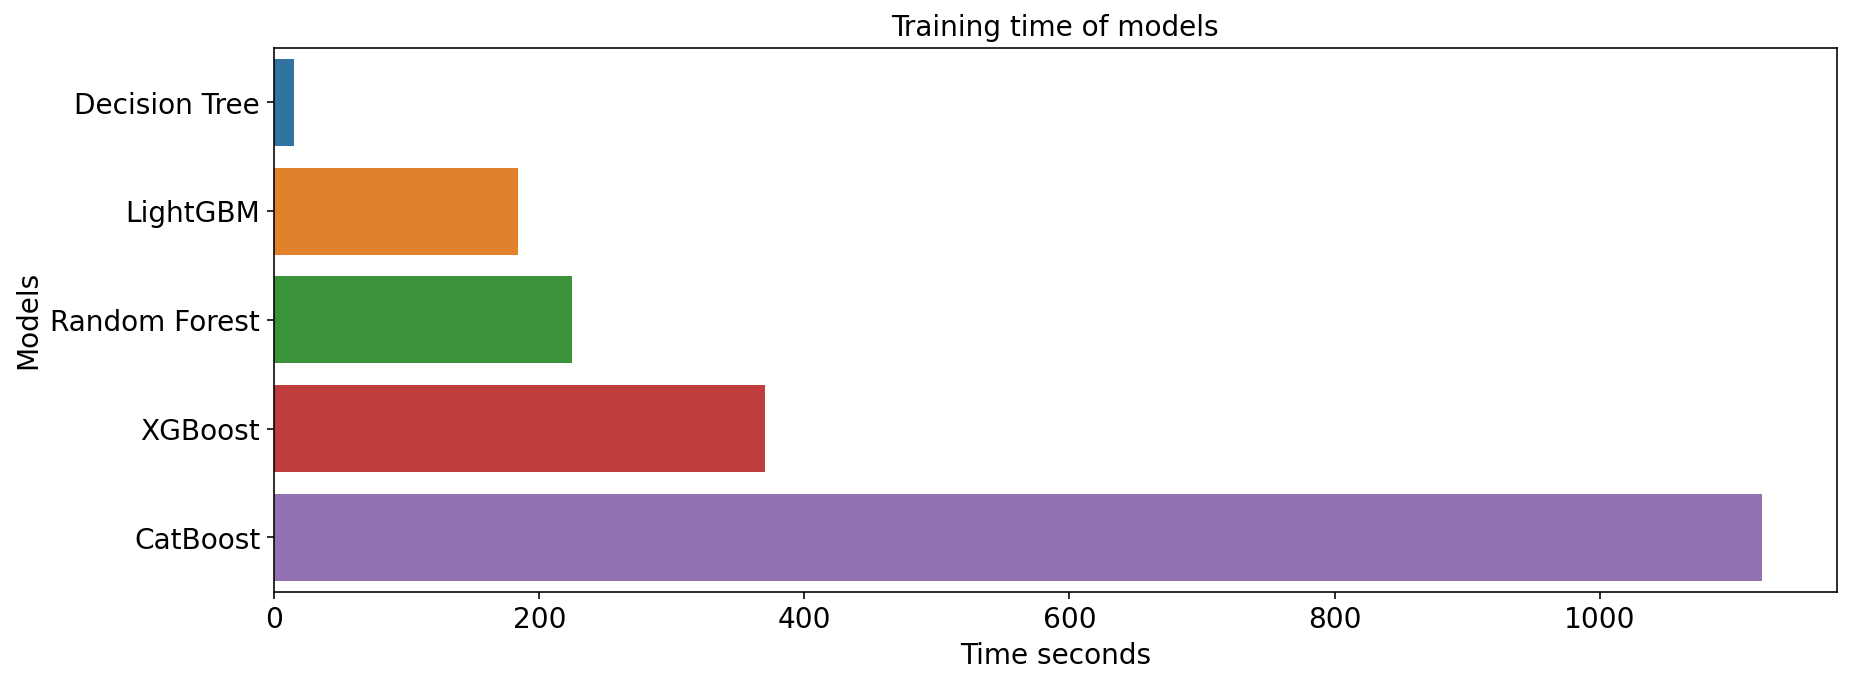

In [109]:
train_time_sorted = approved_models.sort_values(by='training_time_seconds',ascending=True).reset_index()
display(train_time_sorted[['name','training_time']])
drawPlot(train_time_sorted,'training_time_seconds','name','Time seconds','Models','Training time of models','name' )

Decision Tree took less time that others - 15 seconds. Next, LightGBM ~ 3 minutes.

Find the fastest model on prediciton

,name,predict_time
0,Decision Tree,0 days 00:00:00.011354
1,CatBoost,0 days 00:00:00.043162
2,XGBoost,0 days 00:00:00.218077
3,LightGBM,0 days 00:00:00.250325
4,Random Forest,0 days 00:00:00.370468


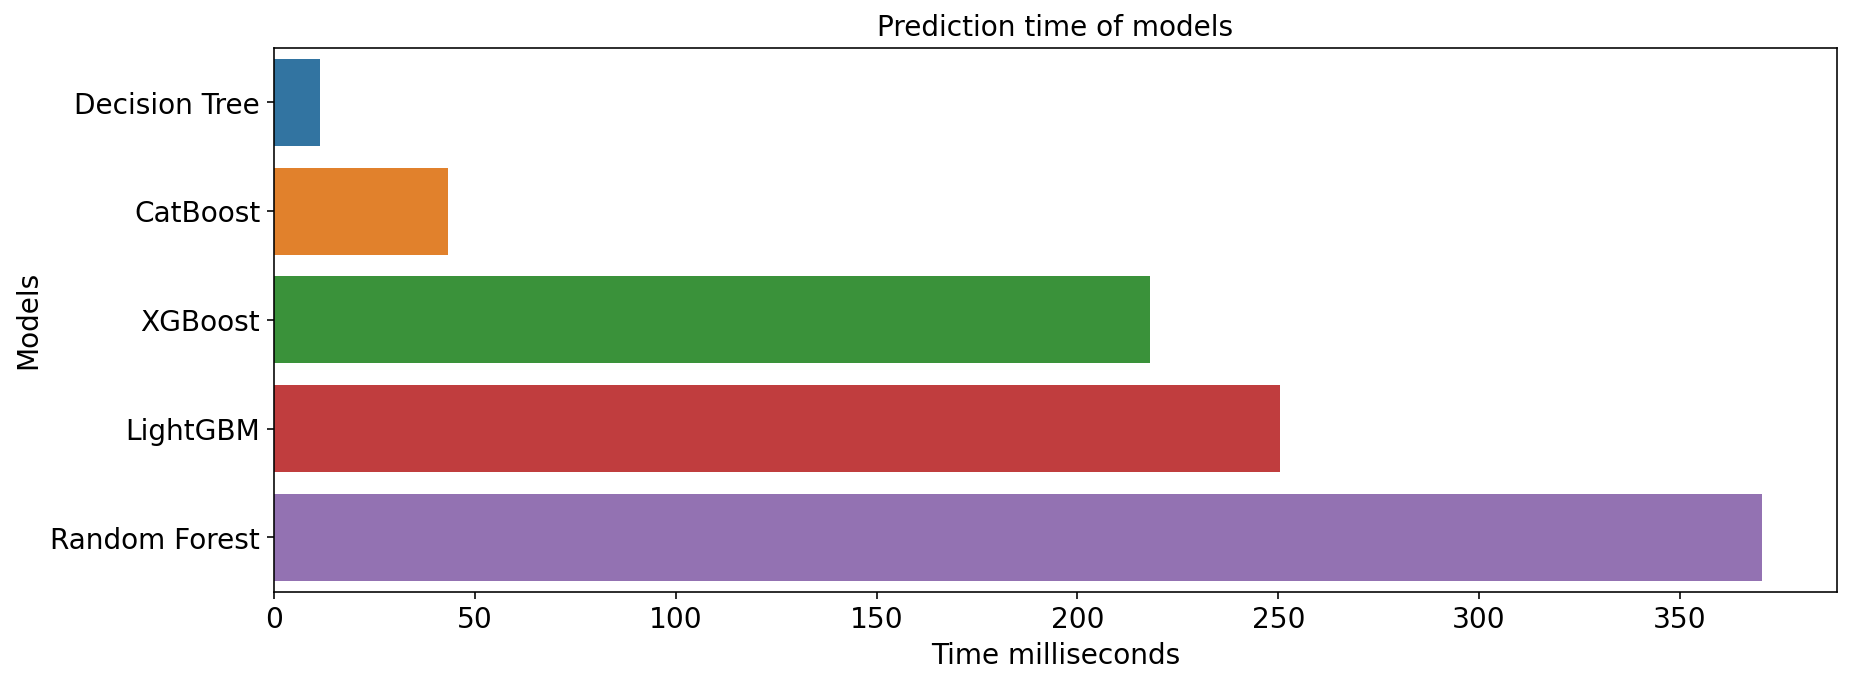

In [111]:
predict_time_sorted = approved_models.sort_values(by='prediction_time_milliseconds',ascending=True).reset_index()
display(predict_time_sorted[['name','predict_time']])
drawPlot(predict_time_sorted,'prediction_time_milliseconds','name','Time milliseconds','Models','Prediction time of models','name' )

Fastest on prediction - Decision Tree and CatBoost. Next, XGBoost, LightGBM. The slowest model - Random Forest.

Based on the results, we will choose the best model - **LightGBM**. Model has good accuracy, average training time and prediction time.

<br>

<a id="results"></a>
# Stage 5 - Results

In the project, we have successfully build Machine Learning model to quickly determine the price of the car. We have found the best model, that corresponds business requirements. In the project: 
- Data preprocessing: 
    1. Processed columns. All columns are converted to lower case
    2. Processed missing data
    3. Applied encoding 
    4. Removed extra columns 
    5. Checked data with custom function. Data has been validated 
    6. Splitted data for cross-validation: splitted data into 2 samples: training and test in ratio (*75/25*).
    7. Standardized columns
    
- Machine Learning models research:
    We have tried many Regression models: Linear Regression, Decision Tree, Random Forest, XGboost, LightGBM, CatBoost. 
    
- Analyzed models based on speed and accuracy: 
    1. Checked model for sanity. All models passed check
    2. Based on the metrics, that correspond business requirements, we found the best model.
    3. Based on the results, we will choose the best model - **LightGBM**. Model has good accuracy, average training time and prediction time.

### Model information

In [112]:
approved_models.query('name == "LightGBM"')

,name,training_time,predict_time,rmse_test,rmse_train,prediction_time_milliseconds,training_time_seconds
3,LightGBM,0 days 00:03:03.830959,0 days 00:00:00.250325,1652.229,1324.424,250.325,183.831
